In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

bold_start = "\033[1m"
underline_start = "\033[4m"
bu_end = "\033[0m"

## Project data

The entire dataset I'm using in this project is scraped from https://growdiaries.com/, as one of the significant weed-growing communities in the world, it holds a large amount of data. Each row represents a data point, each column represents one of the diary features.


### Initial analysis and data refinement:

<small>Nulls: np.nan/NaN/None/NA</small><br>
Strating with testing which one of the dry/wet bud weight have less null values and set it as the target variable. <br>
After, I was looking for the number of null values in each feature nd wrote it into a dictionery, that's the way to find out the features contains null and how many.


In [2]:
full_df = pd.read_csv("GrowDiariesRowData.csv")
full_df["bud_dry_weight"].isna().sum(), full_df["bud_wet_weight"].isna().sum()

(5676, 4091)

In [3]:
full_df = full_df.drop("bud_dry_weight", axis=1)

In [4]:
# Showing all the features with nulls
def count_nulls(df):
    null_dict = {}
    for i in df.columns:
        if df[i].isnull().values.any():
            null_dict[i] = df[i].isnull().sum()
    return sorted(null_dict.items(), key=lambda x: x[1])


# Code reuse from: https://stackoverflow.com/questions/29530232/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe, https://www.codingem.com/python-sort-dictionary/,

count_nulls(full_df)

[('diary_name', 1),
 ('strain', 2),
 ('strains_company', 2),
 ('weeks_to_harvest', 3),
 ('watering', 489),
 ('soil', 858),
 ('light_watt', 1462),
 ('num_of_plants', 1621),
 ('nutrients', 2074),
 ('grow_techniques', 2397),
 ('grow_room_size', 3675),
 ('germination', 3995),
 ('bud_wet_weight', 4091)]

In [5]:
full_df = full_df.dropna(subset=["bud_wet_weight", "num_of_plants", "light_watt"])
count_nulls(full_df), full_df.shape

([('diary_name', 1),
  ('watering', 168),
  ('soil', 306),
  ('nutrients', 752),
  ('grow_room_size', 809),
  ('grow_techniques', 1091),
  ('germination', 1853)],
 (5027, 16))

The other features but gremination can be filled with the median, different category or any rational way that fits the each feature. For the germination I will look for the unique values and try to figure it out from it.


In [6]:
full_df["germination"].value_counts()

germination
Paper Towel              1195
Glass Of Water            727
Directly In Substrate     642
Other                     271
Peat Pellet               244
Rockwool Cube              95
Name: count, dtype: int64

In [7]:
full_df = full_df.drop("germination", axis=1)

As I see it, we have more null values than unique values so I'll drop it.


In [8]:
null_feat = dict(count_nulls(full_df)).keys()
null_feat

dict_keys(['diary_name', 'watering', 'soil', 'nutrients', 'grow_room_size', 'grow_techniques'])

In [9]:
# Code reuse: https://stackoverflow.com/questions/58994588/how-can-i-add-the-counts-to-the-histogram-plot
def get_feature_hist(df, cols, figsize=(10, 10), rotation=0):
    fig, ax = plt.subplots(1, len(cols))
    for i, col in enumerate(cols):
        if len(cols) > 1:
            axis = ax[i]
        else:
            axis = ax
        col_vals = full_df[col].value_counts()
        bins = range(len(col_vals) + 1)
        ticks = range(len(col_vals))
        labelist = [x[:15] + "..." if len(x) > 15 else x for x in col_vals.keys()]
        df[col].hist(
            grid=False, bins=bins, align="left", figsize=figsize, xrot=rotation
        )
        axis.set_xticks(ticks, labelist, size="small")
        for b, n in enumerate(col_vals):
            axis.text(b - (0.1 * len(str(n))) / 2, n + 15, str(int(n)))

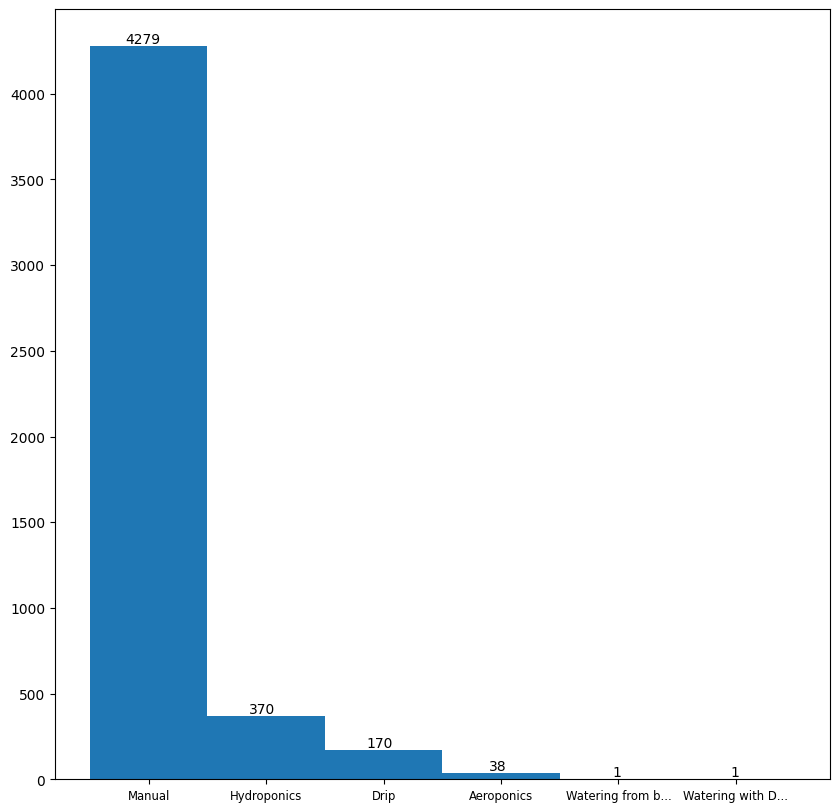

In [10]:
get_feature_hist(full_df, ["watering"])

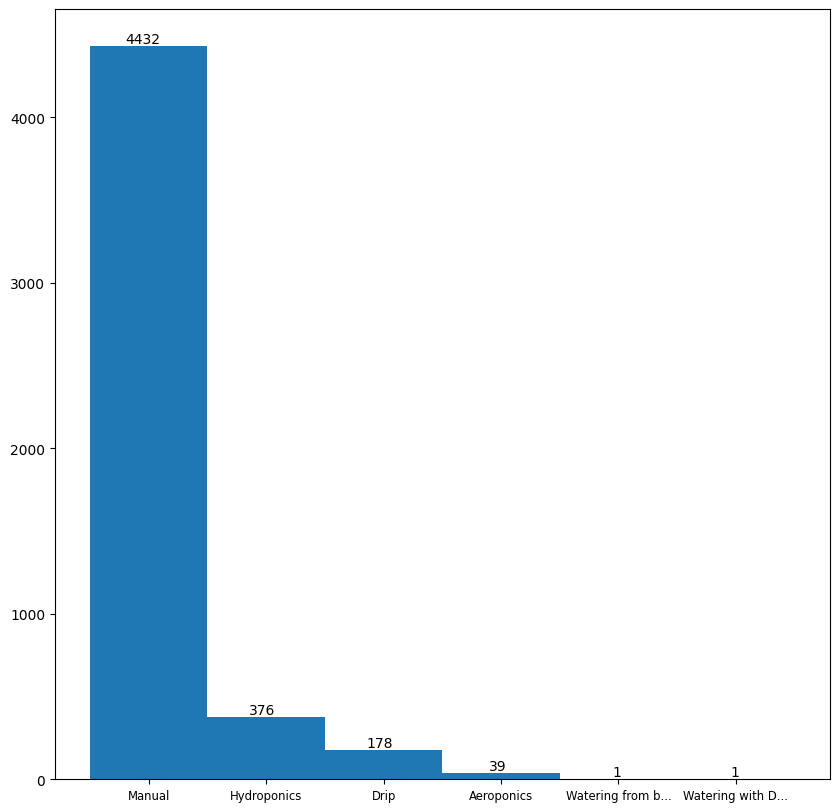

In [11]:
# filling with the forward fill
full_df["watering"] = full_df["watering"].fillna(method="ffill")
get_feature_hist(full_df, ["watering"])

In [12]:
count_nulls(full_df)

[('diary_name', 1),
 ('soil', 306),
 ('nutrients', 752),
 ('grow_room_size', 809),
 ('grow_techniques', 1091)]

In [13]:
def before_after_fill(df, col, method, val=None):
    """
    Shows the differences in the values apperance before and after filling the null values
    return: the feature without nulld
    """
    print("Before:\n", df[col].value_counts()[:10])
    if method == "ffill":
        new_col = df[col].fillna(method=method)
    elif method == "zeros":
        new_col = df[col].fillna(0)
    elif method == "value" and val:
        new_col = df[col].fillna(val)

    print("\nAfter:\n", new_col.value_counts()[:10])
    return new_col

In [14]:
# filling with the forward fill
full_df["nutrients"] = before_after_fill(full_df, ["nutrients"], "ffill")

Before:
 nutrients                 
Advanced Nutrients,           351
General Hydroponics (GHE),    311
BioBizz,                      248
Fox Farm,                     116
Green Buzz Nutrients,         110
PLAGRON.,                      95
Green House Feeding,           90
Canna,                         81
Gaia Green,                    48
Top Crop,                      48
Name: count, dtype: int64

After:
 nutrients                 
Advanced Nutrients,           408
General Hydroponics (GHE),    354
BioBizz,                      292
Fox Farm,                     139
Green Buzz Nutrients,         119
PLAGRON.,                     110
Green House Feeding,          100
Canna,                         89
Top Crop,                      60
Gaia Green,                    60
Name: count, dtype: int64


In [15]:
# Missing values were filled using the most frequent value
full_df["soil"] = before_after_fill(
    full_df, ["soil"], "value", full_df["soil"].mode()[0]
)

Before:
 soil                                                           
Soil Grow Medium,                                                  1242
Soil Grow Medium,Perlite Grow Medium,                               481
Coco Coir Grow Medium,Perlite Grow Medium,                          445
Coco Coir Grow Medium,                                              174
Soil Grow Medium,Perlite Grow Medium,Coco Coir Grow Medium,         110
Expanded Clay Grow Medium,                                           78
Soil Grow Medium,Coco Coir Grow Medium,                              74
Soil Grow Medium,Coco Coir Grow Medium,Perlite Grow Medium,          71
Soil Grow Medium,Perlite Grow Medium,Expanded Clay Grow Medium,      60
Mineral Wool Grow Medium,                                            55
Name: count, dtype: int64

After:
 soil                                                           
Soil Grow Medium,                                                  1548
Soil Grow Medium,Perlite Grow Medium

#### A grower might not apply any grow technique so the null values will be replaced by zeros


In [16]:
full_df["grow_techniques"] = before_after_fill(full_df, ["grow_techniques"], "zeros")

Before:
 grow_techniques         
LST,Defoliation,            469
LST,                        410
Defoliation,                328
Topping,                    171
Topping,LST,Defoliation,    163
Defoliation,LST,            148
Topping,Defoliation,        120
LST,Topping,Defoliation,     81
Topping,LST,                 49
ScrOG,                       46
Name: count, dtype: int64

After:
 grow_techniques         
0                           1091
LST,Defoliation,             469
LST,                         410
Defoliation,                 328
Topping,                     171
Topping,LST,Defoliation,     163
Defoliation,LST,             148
Topping,Defoliation,         120
LST,Topping,Defoliation,      81
Topping,LST,                  49
Name: count, dtype: int64


In [17]:
full_df.isna().all()

diary_name          False
strain              False
strains_company     False
light_watt          False
nutrients           False
watering            False
soil                False
grow_techniques     False
grow_room_size      False
weeks_to_harvest    False
num_of_plants       False
likes               False
comments            False
views               False
bud_wet_weight      False
dtype: bool

Now, there are no null values in the dataset, now it is ready to convert it


In [18]:
print(full_df.shape)
full_df.head()

(5027, 15)


,diary_name,strain,strains_company,light_watt,nutrients,watering,soil,grow_techniques,grow_room_size,weeks_to_harvest,num_of_plants,likes,comments,views,bud_wet_weight
0,#CannapediaGrowersCup4th,Runtz,Zamnesia Seeds,215 watt,"Advanced Nutrients,General Hydroponics (GHE),",Manual,"Soil Grow Medium,Coco Coir Grow Medium,Perlite...","Transplant,Transplantation,Defoliation,Repelle...",1,18,1.0,50,20,950,1130.0
3,Gorilla punch (fast buds),Gorilla Punch Auto,Fast Buds,400 watt,"Advanced Nutrients,General Hydroponics (GHE),",Manual,"Soil Grow Medium,Perlite Grow Medium,Coco Coir...","LST,",NaN,11,1.0,52,7,306,51.0
6,Sensi amnesia XXL auto,Sensi Amnesia Auto,Sensi Seeds,300 watt,"Advanced Nutrients,General Hydroponics (GHE),",Manual,"Soil Grow Medium,","Topping,LST,Defoliation,",NaN,11,1.0,31,11,285,60.0
7,Rozay Sensible,Pink Rozay x Strawberry Banana Auto,Original Sensible Seeds,300 watt,"Advanced Nutrients,General Hydroponics (GHE),",Manual,"Soil Grow Medium,Perlite Grow Medium,","Topping,Defoliation,",NaN,11,1.0,22,10,156,55.0
8,Gelato Fastbuds,Gelato Auto,Fast Buds,300 watt,"Advanced Nutrients,General Hydroponics (GHE),",Manual,"Soil Grow Medium,Perlite Grow Medium,","Topping,Defoliation,",NaN,12,2.0,11,6,177,110.0


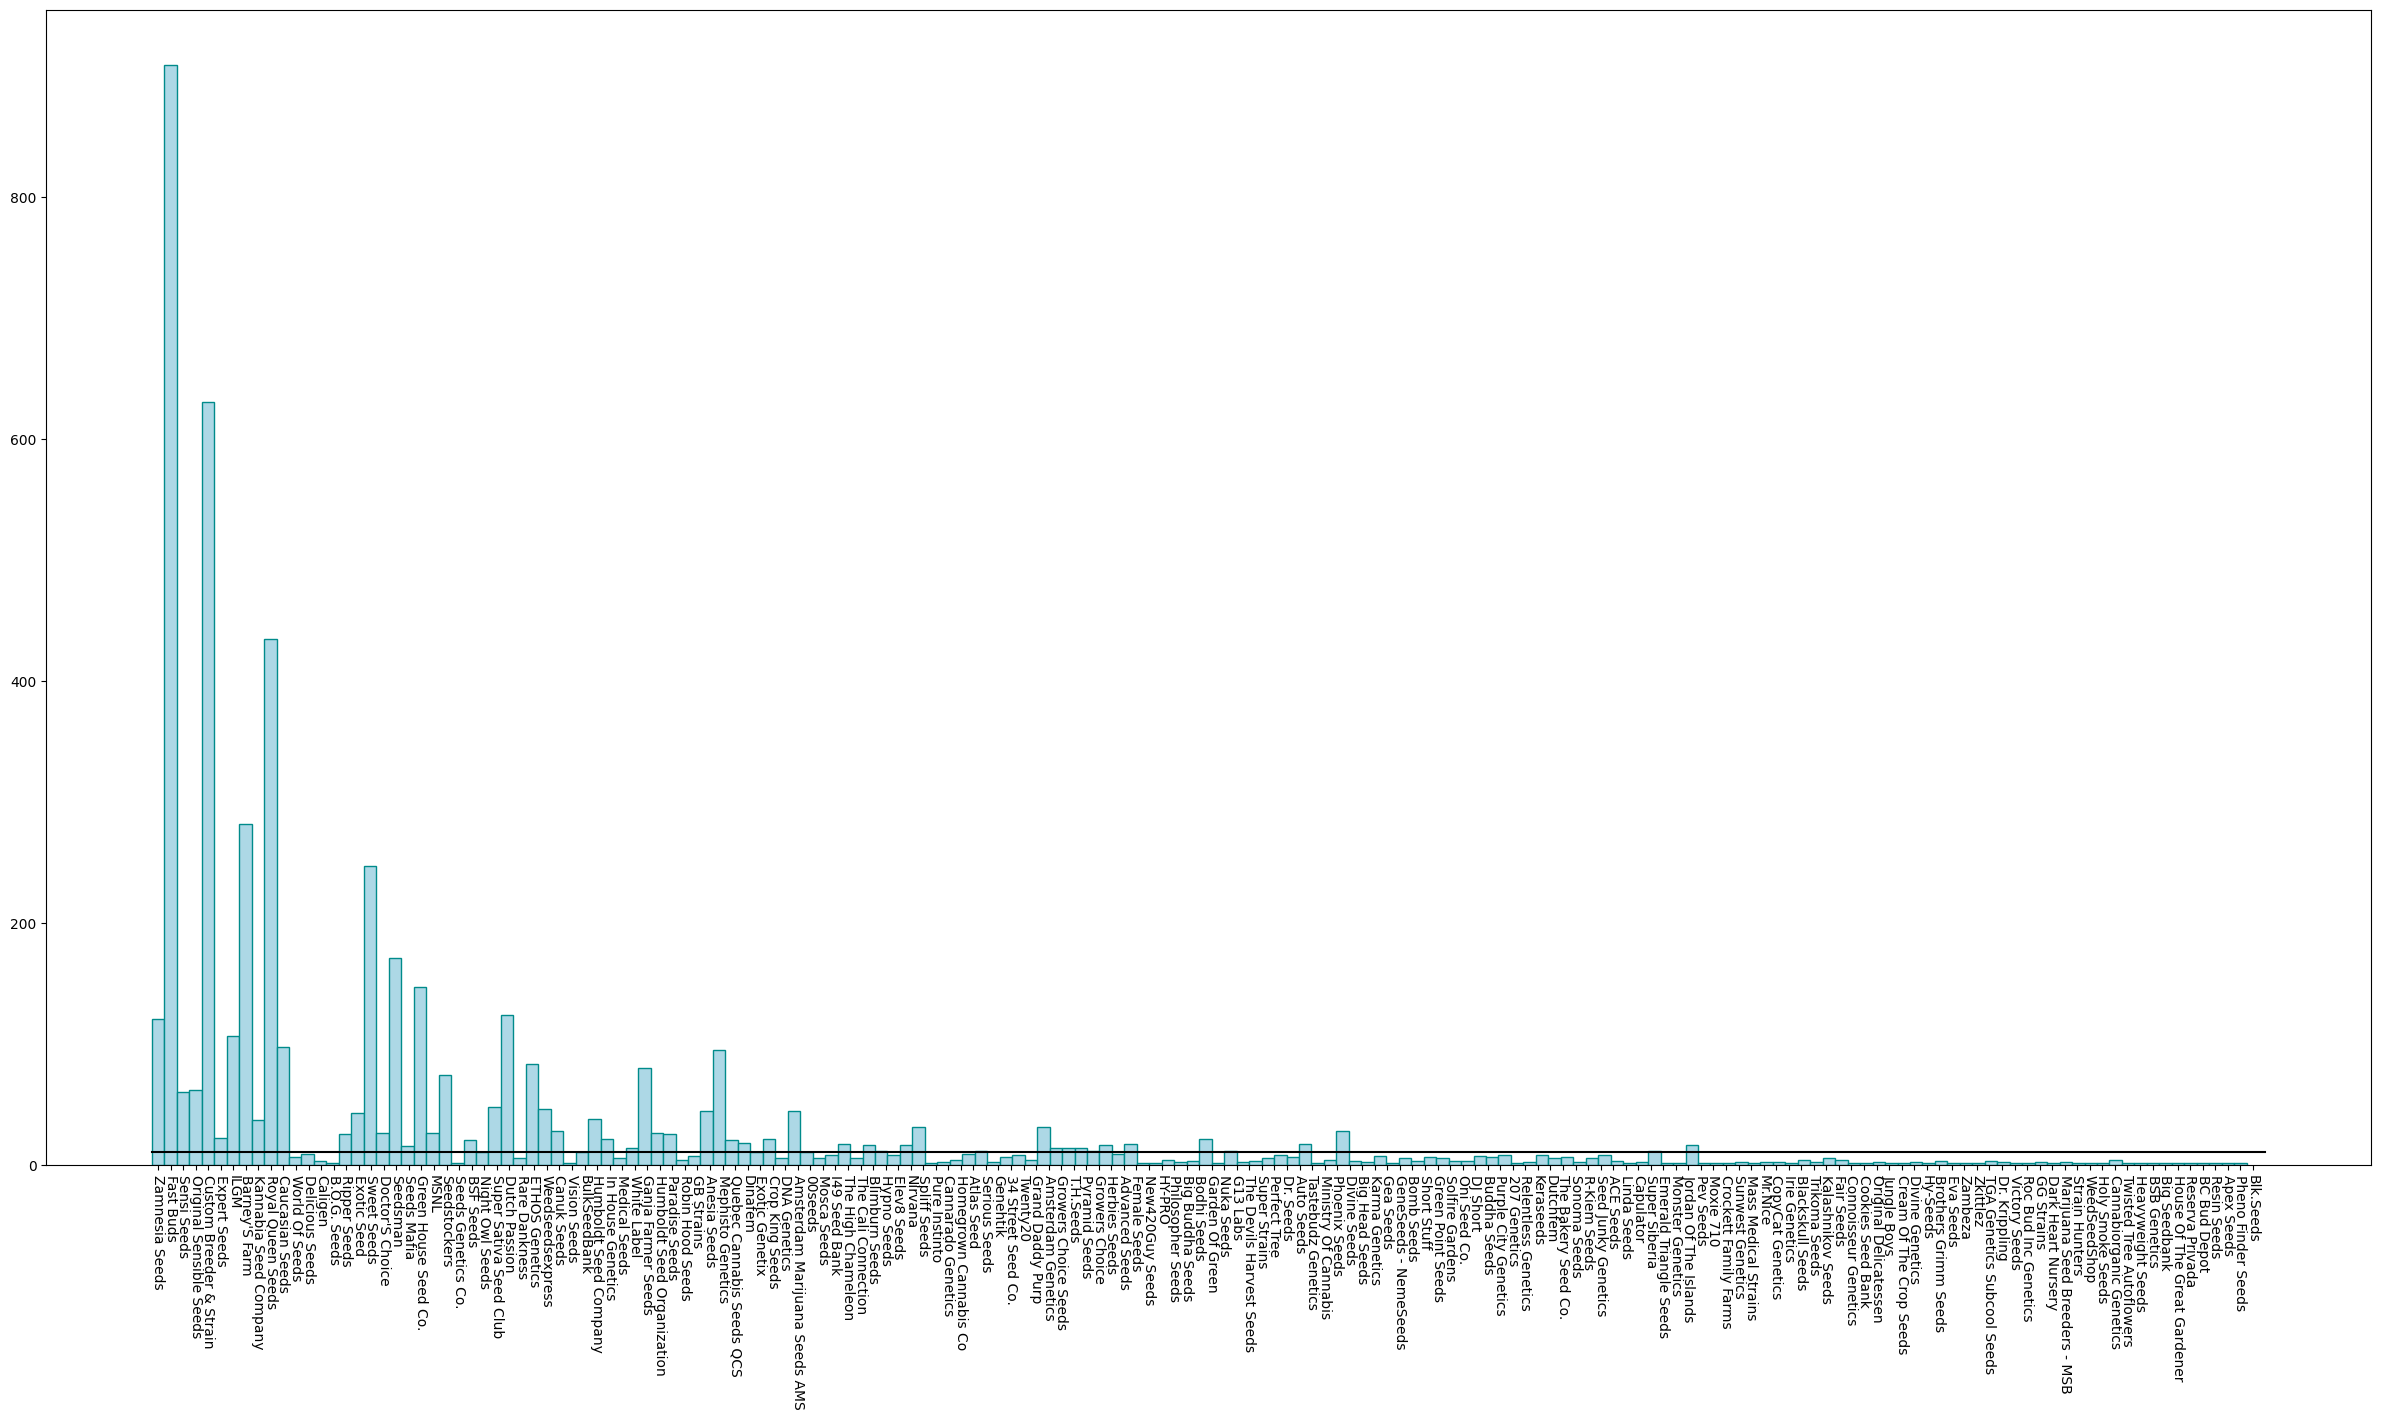

In [19]:
# The line shows the threshold (10)
bins = full_df["strains_company"].value_counts().count()
full_df["strains_company"].hist(
    figsize=(30, 15),
    xrot=-90,
    edgecolor="darkcyan",
    bins=bins,
    grid=False,
    align="left",
    color="lightblue",
)
plt.plot([-0.5, bins], [10, 10], color="black", lw=1.5)

In [20]:
# If the company appears more than 10 times it gets a unique value, otherwise it gets 1. (Higher number == Appeared more)
companies_list = full_df["strains_company"].value_counts()[
    full_df["strains_company"].value_counts() > 10
]
companies_dict = {comp: i + 2 for i, comp in enumerate(reversed(companies_list.keys()))}
for comp in (
    full_df["strains_company"]
    .value_counts()[full_df["strains_company"].value_counts() <= 10]
    .keys()
):
    companies_dict[comp] = 1
full_df["strains_company"] = full_df["strains_company"].map(companies_dict)

<Axes: >

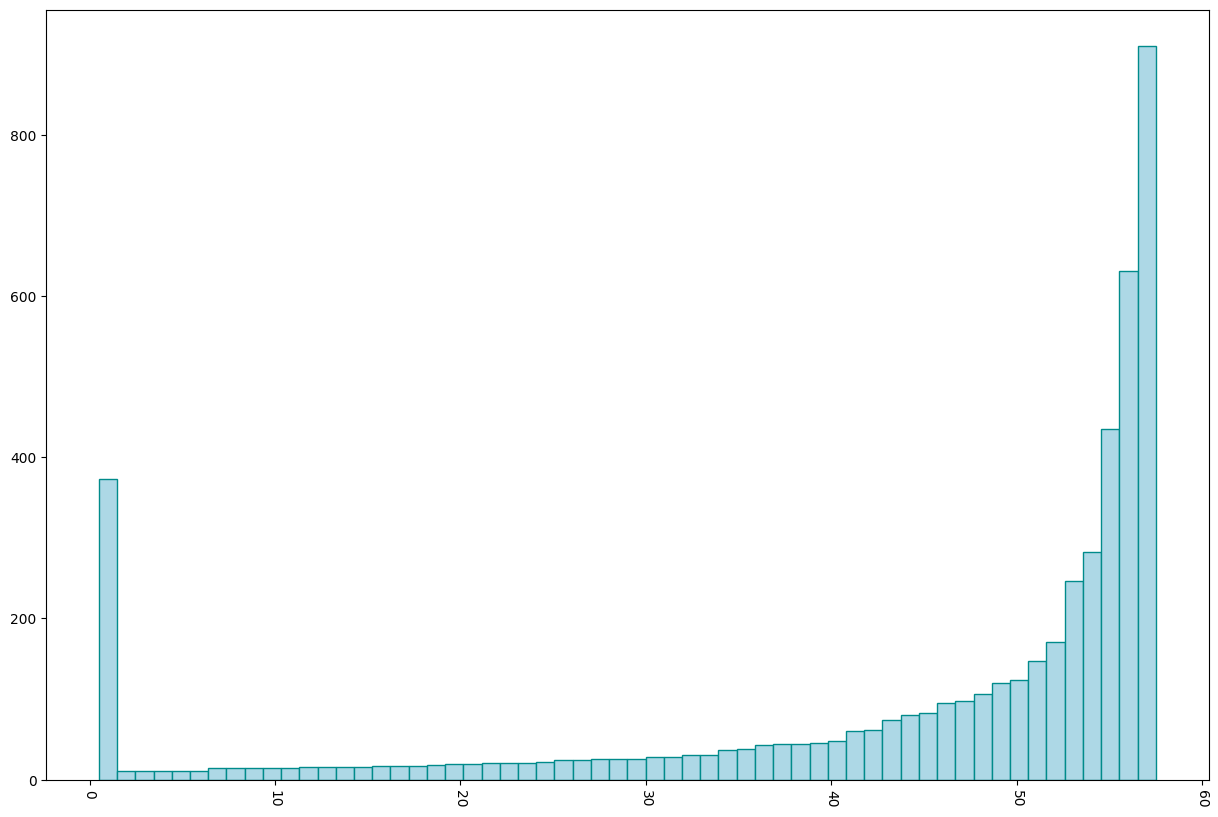

In [21]:
bins = full_df["strains_company"].value_counts().count()
full_df["strains_company"].hist(
    figsize=(15, 10),
    xrot=-90,
    edgecolor="darkcyan",
    bins=bins,
    grid=False,
    align="left",
    color="lightblue",
)

In [22]:
print(
    "The number of strains in the data "
    + bold_start
    + underline_start
    + str(full_df["strain"].value_counts().count())
    + bu_end
)
print(
    "\nThe number of strains with 5 or more appearances in the data "
    + bold_start
    + underline_start
    + str(
        full_df["strain"].value_counts()[full_df["strain"].value_counts() > 5].count()
    )
    + bu_end
)

The number of strains in the data 2111

The number of strains with 5 or more appearances in the data 171


In [23]:
strain_list = full_df["strain"].value_counts()[full_df["strain"].value_counts() > 5]
strain_dict = {comp: i + 2 for i, comp in enumerate(reversed(strain_list.keys()))}
for strain in (
    full_df["strain"].value_counts()[full_df["strain"].value_counts() <= 5].keys()
):
    strain_dict[strain] = 1
full_df["strain"] = full_df["strain"].map(strain_dict)

In [24]:
light_wat_int = []
for e in full_df["light_watt"]:
    if "watt" not in e:
        t = re.findall("[0-9]{2,}[W|X]", e)
        if not t:
            light_wat_int.append(np.nan)
        else:
            light_wat_int.append(int(t[0][:-1]))
    else:
        light_wat_int.append(int(e.split(" ")[0]))

full_df.insert(4, "light_new", light_wat_int)
full_df = full_df.drop("light_watt", axis=1)

## EDA & Visualization


In [25]:
def count_vals(df, col):
    count_lst = []
    # count the number of nutrients used
    for val in full_df[col]:
        try:
            val_count = len(val.split(",")) - 1
        except:
            val_count = val
        count_lst.append(val_count)

    return count_lst

In [26]:
nutrients_len_list = count_vals(full_df, "nutrients")

full_df.insert(6, "nutrients_count", nutrients_len_list)
full_df = full_df.drop("nutrients", axis=1)

In [27]:
# Mapping the watering methods to numbers
watering_dict = {
    watering: i
    for i, watering in enumerate(reversed(full_df["watering"].value_counts().keys()))
}
full_df["watering"] = full_df["watering"].map(watering_dict)

In [28]:
soil_lst = count_vals(full_df, "soil")

full_df.insert(9, "soils_count", soil_lst)
full_df = full_df.drop("soil", axis=1)

In [29]:
grow_lst = count_vals(full_df, "grow_techniques")

full_df.insert(11, "grow_techniques_count", grow_lst)
full_df = full_df.drop("grow_techniques", axis=1)

In [30]:
full_df = full_df[full_df['grow_room_size'].str.contains(r'([a-z]|[A-Z])') == False]

C:\Users\talro\AppData\Local\Temp\ipykernel_16324\714761892.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  full_df = full_df[full_df['grow_room_size'].str.contains(r'([a-z]|[A-Z])') == False]


In [31]:
full_df = full_df.dropna().drop_duplicates()
full_df

,diary_name,strain,strains_company,light_new,watering,nutrients_count,grow_room_size,soils_count,weeks_to_harvest,num_of_plants,grow_techniques_count,likes,comments,views,bud_wet_weight
0,#CannapediaGrowersCup4th,142,50,215.0,5,2,1,3,18,1.0,6,50,20,950,1130.00
9,Знакомство с Ухтой,1,57,300.0,5,2,0.8,2,17,1.0,6,29,21,319,431.00
10,Jive S-2 (Auto) R-2,1,25,1100.0,5,1,1.83,1,10,2.0,8,12,0,750,650.00
13,Wedding Cake Autoflower,1,49,150.0,4,3,0.26,2,13,1.0,3,26,12,554,822.14
20,Mommas Meet 12/12,1,55,300.0,5,5,4.88,2,27,1.0,0,40,12,356,226.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,Exotic genetix: fizzy drank,1,57,650.0,5,2,13.12,2,20,1.0,4,61,20,2449,4.90
9991,Girl scout cookies,1,1,650.0,5,2,13.12,3,23,1.0,4,52,15,1193,7.37
9992,Freebie tester: purple gorilla x sour d.,1,57,650.0,5,2,13.12,2,20,1.0,4,54,17,581,4.80
9993,Exotic genetixs: Dreamcicle,1,1,650.0,5,2,13.12,2,20,1.0,4,28,17,880,4.16


In [32]:
# Convert to int
full_df["weeks_to_harvest"] = [int(t) for t in full_df["weeks_to_harvest"]]

<Axes: >

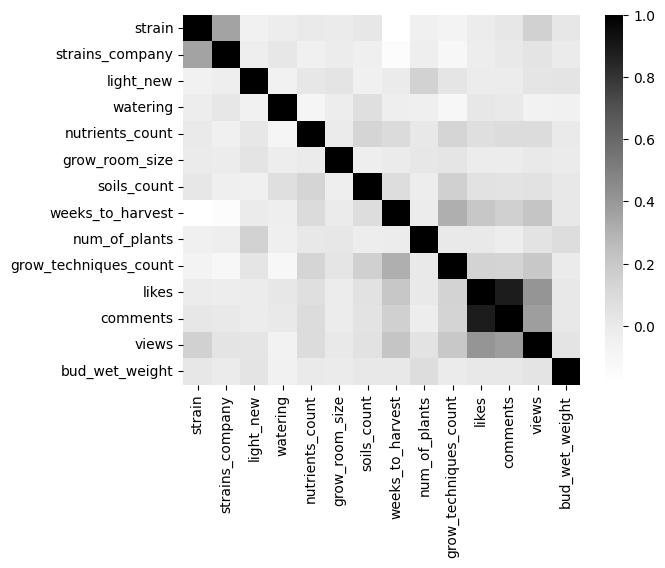

In [33]:
# Correlation grid
sns.heatmap(full_df.drop("diary_name", axis=1).corr(), cmap="Greys")

In [34]:
full_df[full_df['grow_room_size'] == 'Custom']

full_df["grow_room_size"]

0           1
9         0.8
10       1.83
13       0.26
20       4.88
        ...  
9990    13.12
9991    13.12
9992    13.12
9993    13.12
9995     6.24
Name: grow_room_size, Length: 3970, dtype: object

##### The correlation between likes and comments is quite obvious, and later I will use PCA to create new orthogonal basis vectors for it, in order to assess whether user engagement could lend credibility to a diary.


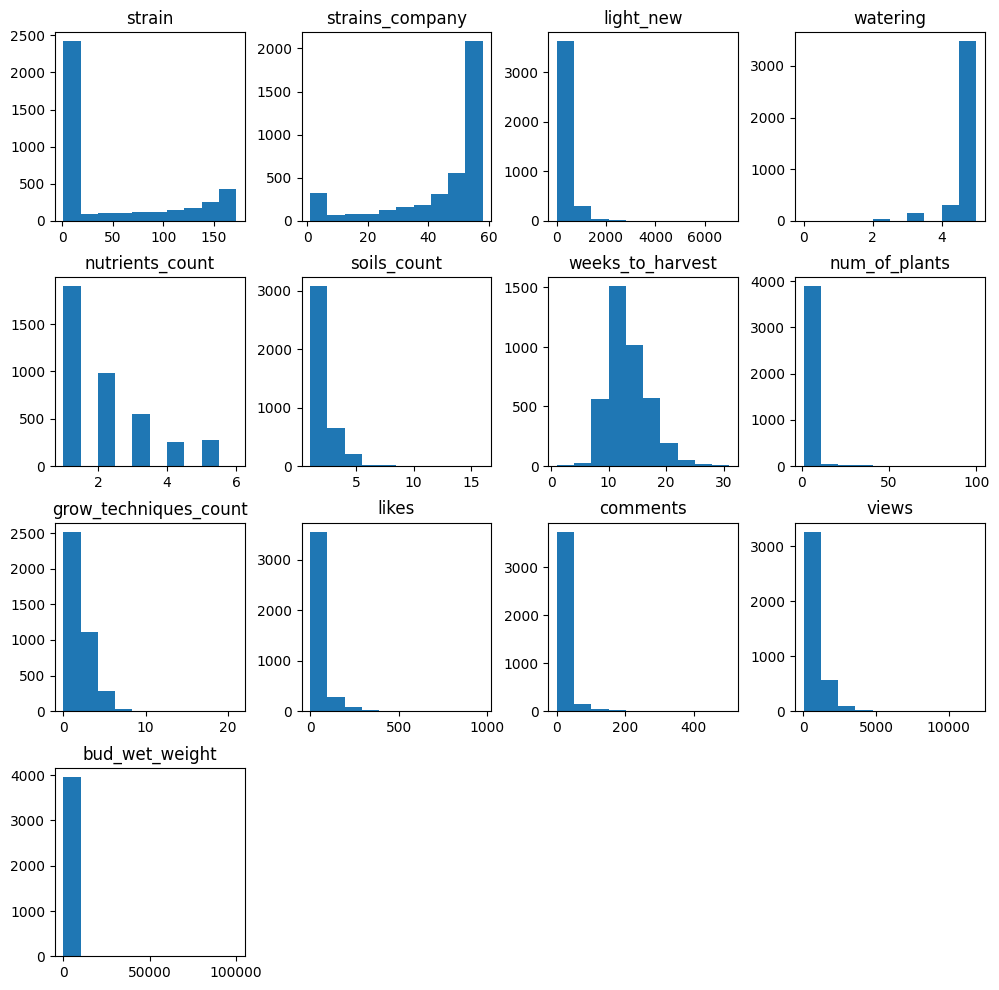

In [35]:
full_df.hist(figsize=(12, 12), grid=False)
print()

<Axes: ylabel='count'>

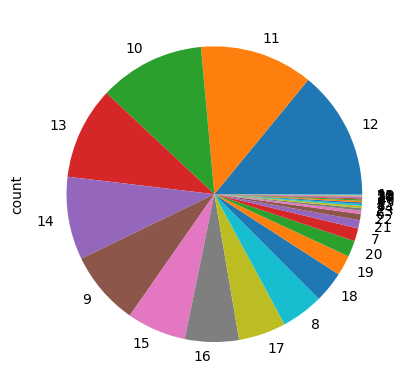

In [36]:
full_df["weeks_to_harvest"].value_counts().plot(kind='pie')

### Outliers treatment


In [37]:
def plot_outliers(df, lst, figtitle):
    fig, ax = plt.subplots(1, 7, figsize=(20, 8))
    i = 0
    fig.suptitle(figtitle, fontsize=16)
    for c in lst:
        ax[i].boxplot(df[c])
        ax[i].set_title(c)
        i += 1


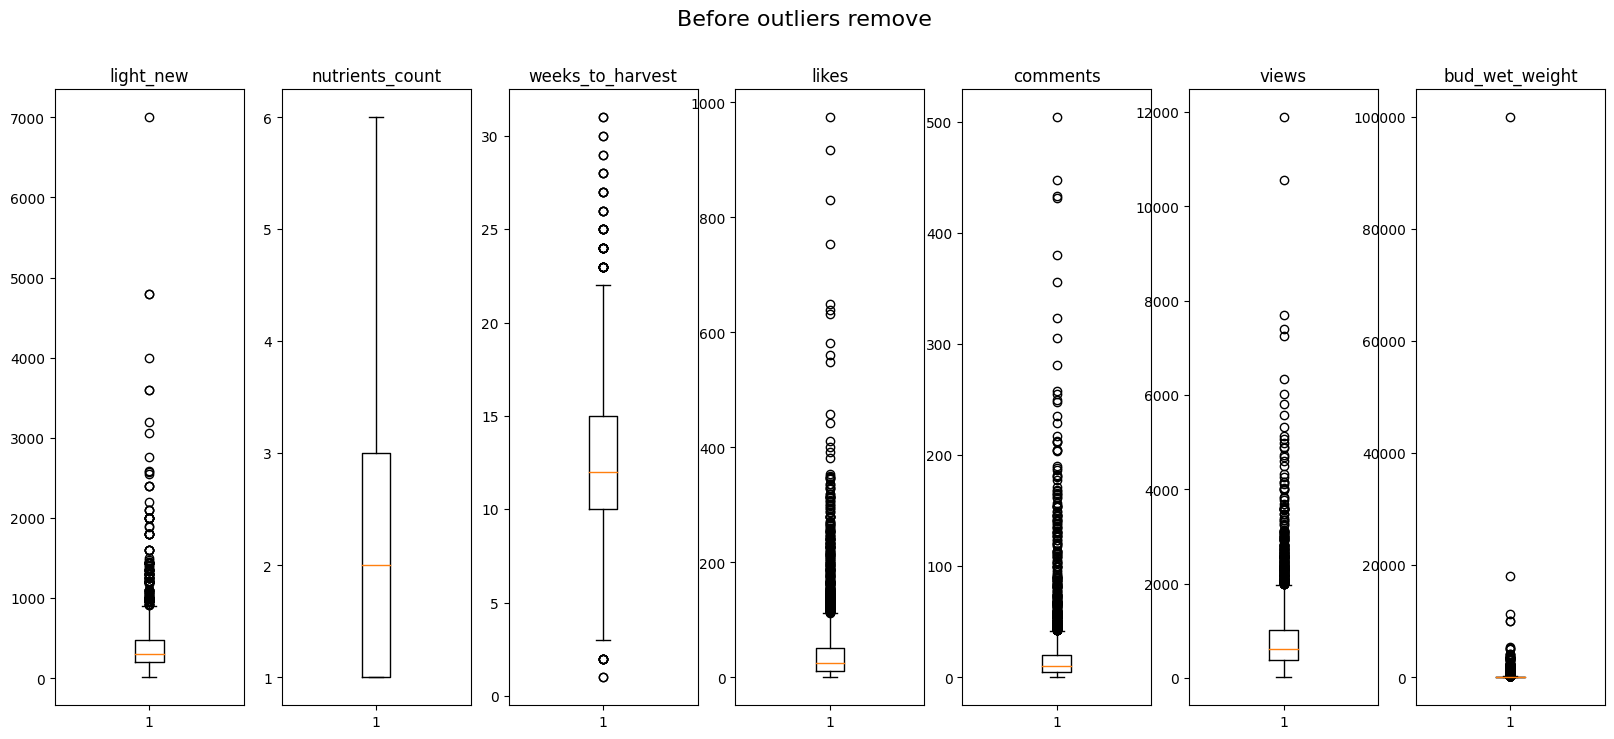

In [38]:
plot_outliers(
    full_df,
    [
        "light_new",
        "nutrients_count",
        "weeks_to_harvest",
        "likes",
        "comments",
        "views",
        "bud_wet_weight",
    ],
    "Before outliers remove",
)

In [39]:
def outlier_detection_iqr(df, column_list, high_bound=1.5, low_bound=1.5):
    cdf = df.copy(deep=True)
    for col in cdf.columns:
        if cdf[col].dtype in ["float64", "int64"] and col in column_list:
            Q1 = cdf[col].quantile(0.25)
            Q3 = cdf[col].quantile(0.75)
            IQR = Q3 - Q1
            cdf.loc[(cdf[col] < (Q1 - low_bound * IQR)), col] = np.nan
            cdf.loc[(cdf[col] > (Q3 + high_bound * IQR)), col] = np.nan

    return cdf

#### Before removing bud wet weight outliers I disire that my traget vector will have values higher than 1. As I see it, less than 1 oz of harvest is really small growth


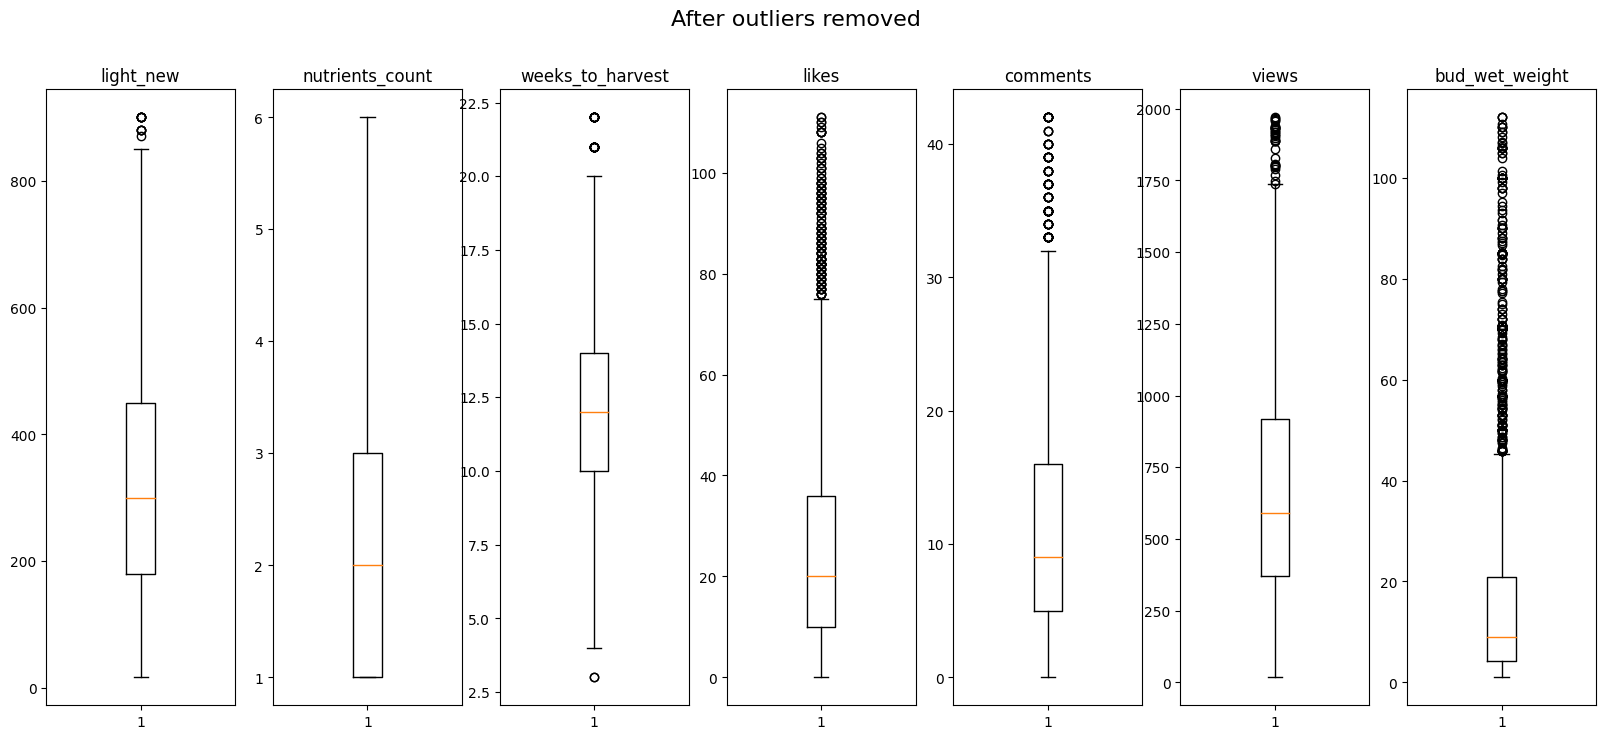

In [40]:
full_df = full_df[full_df["bud_wet_weight"] > 1]

rel_cols = [
            "light_new",
            "nutrients_count",
            "weeks_to_harvest",
            "likes",
            "comments",
            "views",
]
full_df = outlier_detection_iqr(full_df, rel_cols).dropna()
full_df = outlier_detection_iqr(full_df, ['bud_wet_weight'], 0).dropna()
plot_outliers(
    full_df,
    rel_cols + ['bud_wet_weight'],
    "After outliers removed",
)

##### Following the previous question about user engagement, now I'm trying to find out if there is a direct correlation between the number of finances and time invested in a diary (for example, if all highly engaged diaries tend to contain plenty of nutrients kinds?)


<Axes: xlabel='likes', ylabel='comments'>

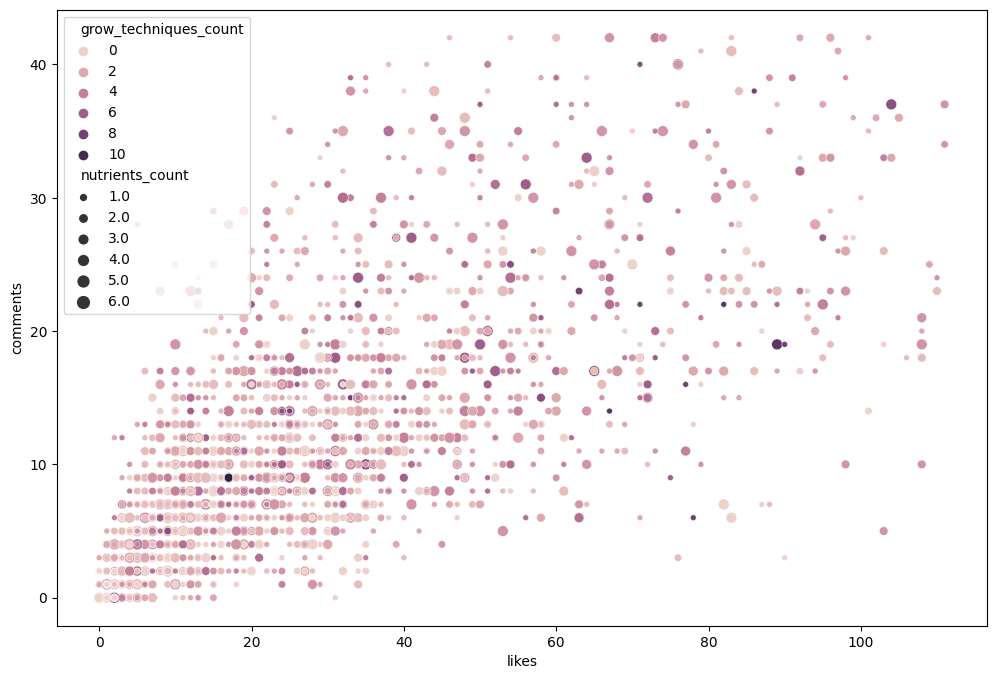

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.scatterplot(
    data=full_df,
    x="likes",
    y="comments",
    size="nutrients_count",
    hue="grow_techniques_count",
    ax=ax,
)

In [42]:
def col_to_num(df):
    col_to_num = {}
    k = 0
    for col in df.columns:
        col_to_num[col] = k
        k += 1
    return col_to_num

#### Preforming PCA to likes and comments + Changing the indecies to diary_name


In [43]:
import sklearn.decomposition as skd

engagement_pca = full_df[["likes", "comments"]]
pca = skd.PCA(n_components=2)
pca.fit(engagement_pca)
data_pca = pca.transform(engagement_pca)
col_dict = col_to_num(full_df)
index = min(col_dict["likes"], col_dict["comments"])
full_df.insert(index, "engagement_1", 0)
full_df.insert(index + 1, "engagement_2", 0)
full_df["engagement_1"] = data_pca[:, 0]
full_df["engagement_2"] = data_pca[:, 1]
# full_df.set_index("diary_name", inplace=True)

In [44]:
np.round(full_df[["likes", "comments"]].corr(), 2)

,likes,comments
likes,1.0,0.7
comments,0.7,1.0


In [45]:
np.round(full_df[["engagement_1", "engagement_2"]].corr(), 2)

,engagement_1,engagement_2
engagement_1,1.0,0.0
engagement_2,0.0,1.0


In [46]:
full_df = full_df.drop(["likes", "comments"], axis=1)

In this point we are ready to preform the supervised machine learning.

"The most significant loss in weight occurred in 1–3 days of the drying process and weights plateaued after one week. Cannabis lost between 25 and 77% of its original weight"
https://www.sciencedirect.com/science/article/abs/pii/S2468170916300868
So 

In [47]:
ounce_to_gram = 28.3495231 
temp = full_df.copy(deep=True)
# temp['bud_wet_weight'] = pd.qcut(np.int16(full_df['bud_wet_weight'] * ounce_to_gram), 5)
temp['bud_wet_weight'] = np.int16(full_df['bud_wet_weight'] * ounce_to_gram)


In [48]:
# temp = temp[temp['bud_wet_weight'] < 400]
# temp

In [49]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression


In [50]:
def calculate_train_test_scores(regressor, X_train, X_test, y_train, y_test):
    regressor.fit(X_train, y_train)
    y_predicted = regressor.predict(X_test).round(0)
    train_score = regressor.score(X_train,y_train)
    test_score = regressor.score(X_test,y_test)
    print('Train score :',train_score)
    print('Test score :',test_score)
    data = pd.DataFrame({'Predicted weight': y_predicted, 'Real weight': y_test})
    return data, regressor


SyntaxError: invalid syntax (3121655888.py, line 6)

In [51]:
X = temp.drop(['diary_name', 'bud_wet_weight'],axis=1)
y = temp['bud_wet_weight']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=10)

In [52]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [53]:
from sklearn.ensemble import ExtraTreesRegressor
data, reg = calculate_train_test_scores(ExtraTreesRegressor(criterion="friedman_mse"), X_train, X_test, y_train, y_test)
data

Train score : 1.0
Test score : 0.12182528653572278


,Predicted weight,Real weight
7494,348.0,70
7536,259.0,229
3173,209.0,400
655,322.0,2041
9235,325.0,559
...,...,...
9469,199.0,68
7057,618.0,1450
3580,307.0,333
7091,340.0,170


In [54]:
data, reg = calculate_train_test_scores(LogisticRegression(solver='newton-cg'), X_train, X_test, y_train, y_test)
data

Train score : 0.19667389732465654
Test score : 0.01843817787418655


,Predicted weight,Real weight
7494,56,70
7536,60,229
3173,85,400
655,199,2041
9235,54,559
...,...,...
9469,254,68
7057,929,1450
3580,70,333
7091,420,170


In [56]:
from sklearn.ensemble import RandomForestRegressor
data, reg = calculate_train_test_scores(RandomForestRegressor(), X_train, X_test, y_train, y_test)
data

Train score : 0.8910651950824832
Test score : 0.25513866869693147


,Predicted weight,Real weight
7494,203.0,70
7536,288.0,229
3173,250.0,400
655,1508.0,2041
9235,378.0,559
...,...,...
9469,226.0,68
7057,453.0,1450
3580,312.0,333
7091,234.0,170
